# Unsupervised Challenge


The Assignment
-----------------

Based on CBS data, can you discover a cluster of cities with many students? Do the city names in your cluster make sense (i.e., Amsterdam, Rotterdam, Eindhoven, Tilburg, Maastricht, Breda, Utrecht, Enschede, Groningen, Delft, and more)? Bonus question, within your cluster of 'student cities', can you discover which type of schools, universities are present (e.g., technical ones, social studies?)

In [2]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import csv

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans

# bigger plots
plt.rcParams['figure.figsize'] = [20, 15]

pd.options.mode.chained_assignment = None

In [3]:
import os

# Download the data from our GitLab page
!wget https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/kwb-2018-toelichting.csv
!wget https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/kwb-2018.csv

data_directory = os.path.join('/content/')

--2023-11-21 10:21:03--  https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/kwb-2018-toelichting.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3375 (3.3K) [text/plain]
Saving to: ‘kwb-2018-toelichting.csv’

kwb-2018-toelichtin 100%[===================>]   3.30K  --.-KB/s    in 0s      

2023-11-21 10:21:03 (47.8 MB/s) - ‘kwb-2018-toelichting.csv’ saved [3375/3375]

--2023-11-21 10:21:03--  https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/kwb-2018.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3774153 (3.6M) [text/plain]
Saving to: ‘kwb-2018.csv’

kwb-2018.csv        100%[===================>]   3.60M  --.-KB/s    in 0.03s   

2023-11-2

In [4]:
column_reference_table = {}
with open(os.path.join(data_directory, "kwb-2018-toelichting.csv"), encoding="latin1") as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        column_reference_table[row[0]] = row[1]

In [5]:
with open(os.path.join(data_directory, "kwb-2018.csv"), encoding="latin1") as file:
    data = pd.read_csv(file, sep =';')
print(f"The available features:\t {list(data)}")

The available features:	 ['gwb_code_10', 'gwb_code_8', 'regio', 'gm_naam', 'recs', 'gwb_code', 'ind_wbi', 'a_inw', 'a_man', 'a_vrouw', 'a_00_14', 'a_15_24', 'a_25_44', 'a_45_64', 'a_65_oo', 'a_ongeh', 'a_gehuwd', 'a_gesch', 'a_verwed', 'a_w_all', 'a_nw_all', 'a_marok', 'a_antaru', 'a_suri', 'a_tur', 'a_ov_nw', 'a_hh', 'a_1p_hh', 'a_hh_z_k', 'a_hh_m_k', 'g_hhgro', 'bev_dich', 'a_woning', 'g_woz', 'p_1gezw', 'p_mgezw', 'p_bewndw', 'p_leegsw', 'p_koopw', 'p_huurw', 'p_wcorpw', 'p_ov_hw', 'p_e_o_w', 'p_bjj2k', 'p_bjo2k', 'a_pau', 'a_bst_b', 'a_bst_nb', 'g_pau_hh', 'g_pau_km', 'a_m2w', 'a_opp_ha', 'a_lan_ha', 'a_wat_ha', 'ste_mvs', 'ste_oad']


In [6]:
column_reference_table

{'gwb_code_10': 'gwb code 10',
 'gwb_code_8': 'gwb code 8',
 'regio': 'Regioaanduiding',
 'gm_naam': 'Gemeentenaam',
 'recs': 'Soort regio',
 'gwb_code': 'Codering',
 'ind_wbi': 'Indelingswijziging wijken en buurten',
 'a_inw': 'Aantal inwoners',
 'a_man': 'Mannen',
 'a_vrouw': 'Vrouwen',
 'a_00_14': '0 tot 15 jaar',
 'a_15_24': '15 tot 25 jaar',
 'a_25_44': '25 tot 45 jaar',
 'a_45_64': '45 tot 65 jaar',
 'a_65_oo': '65 jaar of ouder',
 'a_ongeh': 'Ongehuwd',
 'a_gehuwd': 'Gehuwd',
 'a_gesch': 'Gescheiden',
 'a_verwed': 'Verweduwd',
 'a_w_all': 'Westers totaal',
 'a_nw_all': 'Niet-westers totaal',
 'a_marok': 'Marokko',
 'a_antaru': 'Nederlandse Antillen en Aruba',
 'a_suri': 'Suriname',
 'a_tur': 'Turkije',
 'a_ov_nw': 'Overig niet-westers',
 'a_geb': 'Geboorte totaal',
 'p_geb': 'Geboorte relatief',
 'a_ste': 'Sterfte totaal',
 'p_ste': 'Sterfte relatief',
 'a_hh': 'Huishoudens totaal',
 'a_1p_hh': 'Eenpersoonshuishoudens',
 'a_hh_z_k': 'Huishoudens zonder kinderen',
 'a_hh_m_k': 'H

In [7]:
data['recs'].unique()

array(['Land', 'Gemeente', 'Wijk', 'Buurt'], dtype=object)

In [8]:
# data cleaning
data['p_huurw_f'] = pd.to_numeric(data['p_huurw'], downcast="float", errors="coerce") / 100
data['p_huurw_f'].describe()

count    15221.000000
mean         0.317033
std          0.210416
min          0.000000
25%          0.150000
50%          0.270000
75%          0.430000
max          1.000000
Name: p_huurw_f, dtype: float64

In [9]:
selected_region_type = 'Gemeente'

In [10]:
data_for_selected_region_type = data[data.recs == selected_region_type]
data_for_selected_region_type.shape

(380, 57)

### Design features that allows you to answer the question, find the right clusters using some clustering algorithm

Based on CBS data, can you discover a cluster of cities with many students? Do the city names in your cluster make sense? Bonus question, within your cluster of 'student cities', can you discover which type of schools, universities are present (e.g., technical ones, social studies?)

In [11]:
# feature engineering
data_for_selected_region_type['perc_ongehuwd'] = data_for_selected_region_type['a_ongeh'] / (data_for_selected_region_type['a_inw'])
data_for_selected_region_type['perc_vrouwen'] = data_for_selected_region_type['a_vrouw'] / (data_for_selected_region_type['a_inw'])
data_for_selected_region_type['perc_15_24'] = data_for_selected_region_type['a_15_24'] / (data_for_selected_region_type['a_inw'])
data_for_selected_region_type['perc_hh_z_k'] = data_for_selected_region_type['a_hh_z_k'] / (data_for_selected_region_type['a_hh'])
data_for_selected_region_type.head()

gwb_code_10  gwb_code_8       regio     gm_naam      recs gwb_code ind_wbi  \
1       GM0003           3  Appingedam  Appingedam  Gemeente   GM0003       .   
9       GM0005           5       Bedum       Bedum  Gemeente   GM0005       .   
19      GM0009           9    Ten Boer    Ten Boer  Gemeente   GM0009       .   
34      GM0010          10    Delfzijl    Delfzijl  Gemeente   GM0010       .   
64      GM0014          14   Groningen   Groningen  Gemeente   GM0014       .   

     a_inw   a_man  a_vrouw  ...  a_opp_ha  a_lan_ha  a_wat_ha  ste_mvs  \
1    11801    5751     6050  ...      2458      2378        80        3   
9    10475    5235     5240  ...      4496      4454        41        4   
19    7292    3616     3676  ...      4573      4531        42        5   
34   24864   12475    12389  ...     22750     13307      9443        4   
64  202810  101299   101511  ...     10150      9492       658        1   

    ste_oad  p_huurw_f  perc_ongehuwd  perc_vrouwen  perc_15_24  perc_hh_z_k  
1      1051       0.51       0.424795      0.512668    0.101856     0.320397  
9       685       0.31       0.437709      0.500239    0.113126     0.347529  
19      372       0.23       0.443637      0.504114    0.116292     0.329866  
34      677       0.38       0.414776      0.498271    0.105253     0.326504  
64     3456       0.61       0.678399      0.500523    0.235062     0.207996  

[5 rows x 61 columns]

In [12]:
unsupervised_data = data_for_selected_region_type[['perc_15_24','perc_ongehuwd','perc_hh_z_k','p_huurw_f','perc_vrouwen']]
unsupervised_data.shape

(380, 5)

In [13]:
k = 5
kmeans = KMeans(n_clusters=k).fit(unsupervised_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
# predictions for all gemeentes
df_predictions = pd.DataFrame({"cluster" : kmeans.predict(unsupervised_data).tolist()})

# we now want to make a dataset with cluster (the predictions), we first copy the unsupervised dataset
unsupervised_data_w_cluster = unsupervised_data

# assign cluster to dataset
unsupervised_data_w_cluster = unsupervised_data_w_cluster.assign(cluster = df_predictions.values)

# assign the name of gemeente to dataset
unsupervised_data_w_cluster = unsupervised_data_w_cluster.assign(gm_naam = data_for_selected_region_type['gm_naam'].values)

In [15]:
for k_i in range(k):
    print(f"\n\n{unsupervised_data_w_cluster[unsupervised_data_w_cluster['cluster']==k_i][['gm_naam','cluster']]}")



                  gm_naam  cluster
9                   Bedum        0
263             Loppersum        0
449                Winsum        0
837      Ooststellingwerf        0
1150            Coevorden        0
...                   ...      ...
15678      Hollands Kroon        0
15777  Goeree-Overflakkee        0
16119    De Fryske Marren        0
16558         Westerwolde        0
16741         Montferland        0

[94 rows x 2 columns]


                gm_naam  cluster
34             Delfzijl        1
230                Leek        1
309              Almere        1
382         Stadskanaal        1
415             Veendam        1
...                 ...      ...
16038    Krimpenerwaard        1
16241      Gooise Meren        1
16304       Berg en Dal        1
16457         Waadhoeke        1
16628  Midden-Groningen        1

[114 rows x 2 columns]


             gm_naam  cluster
64         Groningen        2
968         Vlieland        2
2648          Arnhem        2
3561       

In [16]:
column_reference_table['perc_15_24'] = '% jonge mensen'
column_reference_table['perc_vrouwen'] = '% vrouwen'

feature_one = 'perc_15_24'
feature_two = 'perc_vrouwen'

plt.scatter(unsupervised_data_w_cluster[feature_one], unsupervised_data_w_cluster[feature_two], c=unsupervised_data_w_cluster['cluster'], cmap=cm.jet)
plt.colorbar()
plt.xlabel(column_reference_table[feature_one])
plt.ylabel(column_reference_table[feature_two])

# comment out for not showing labels
for i, txt in enumerate(unsupervised_data_w_cluster['gm_naam']):
    x_co = unsupervised_data_w_cluster.iloc[i][feature_one]
    y_co = unsupervised_data_w_cluster.iloc[i][feature_two]
    plt.annotate(txt, (x_co, y_co))

In [17]:
from sklearn.decomposition import PCA
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit(unsupervised_data)

# the covariance matrix
print(pca.components_)

plt.plot(pca.explained_variance_)

[[ 0.07316871  0.32016737 -0.31361648  0.89050677  0.02795703]
 [ 0.26256787  0.74348393 -0.42865954 -0.43829592 -0.04937051]
 [ 0.51159693  0.30038939  0.74359437  0.12075019 -0.28376328]
 [-0.78053196  0.49907184  0.36635211  0.01102668  0.08580031]
 [-0.233972   -0.07360716 -0.17535462  0.01386299 -0.95336125]]


In [18]:
pca.n_components = 2
dataset_reduced = pca.fit_transform(unsupervised_data)
dataset_reduced

array([[ 1.41355216e-01, -8.98809540e-02],
       [-4.06432371e-02, -6.77550696e-04],
       [-1.04106374e-01,  4.70048289e-02],
       [ 2.03125795e-02, -4.13659706e-02],
       [ 3.56259570e-01,  1.38597291e-01],
       [-8.29481051e-02,  6.80713136e-02],
       [-5.55127307e-02,  2.56532163e-02],
       [-1.13951921e-04, -1.31572659e-02],
       [-1.79785978e-02, -2.06252129e-02],
       [-6.57216177e-02,  4.05347798e-02],
       [ 6.36416513e-02,  8.66119388e-02],
       [ 2.37172266e-02, -5.61419139e-02],
       [-1.24610107e-02, -1.71684408e-02],
       [ 6.13980825e-04,  5.48213973e-02],
       [-3.43897797e-02,  7.13198375e-03],
       [-8.23842409e-02,  4.51710374e-02],
       [ 1.18261519e-02,  1.02490106e-02],
       [ 9.93394596e-03,  8.46538679e-03],
       [-5.11308343e-02,  1.85614541e-02],
       [ 8.88578072e-02, -3.75503229e-02],
       [ 5.81381559e-02, -8.63586974e-03],
       [-3.24945559e-02,  3.58391453e-02],
       [ 1.70008246e-01,  4.18761234e-02],
       [-1.

In [19]:
k = 5
kmeans = KMeans(n_clusters=k).fit(dataset_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
# predictions for all gemeentes
df_predictions_reduced = pd.DataFrame({"cluster" : kmeans.predict(dataset_reduced).tolist()})

# we now want to make a dataset with cluster (the predictions), we first copy the unsupervised dataset
data_reduced_w_cluster =  pd.DataFrame(dataset_reduced)

# assign cluster to dataset
data_reduced_w_cluster = data_reduced_w_cluster.assign(cluster = df_predictions_reduced.values)

# assign the name of gemeente to dataset
data_reduced_w_cluster = data_reduced_w_cluster.assign(gm_naam = data_for_selected_region_type['gm_naam'].values)

In [21]:
data_reduced_w_cluster

0         1  cluster           gm_naam
0    0.141355 -0.089881        1        Appingedam
1   -0.040643 -0.000678        4             Bedum
2   -0.104106  0.047005        3          Ten Boer
3    0.020313 -0.041366        0          Delfzijl
4    0.356260  0.138597        2         Groningen
..        ...       ...      ...               ...
375 -0.058884  0.027306        3       Meierijstad
376 -0.022431  0.011779        0         Waadhoeke
377 -0.085173 -0.047063        4       Westerwolde
378  0.029364 -0.019974        0  Midden-Groningen
379 -0.023276 -0.034167        0       Montferland

[380 rows x 4 columns]

In [22]:
for k_i in range(k):
    print(f"\n\n{data_reduced_w_cluster[data_reduced_w_cluster['cluster']==k_i][['gm_naam','cluster']]}")



              gm_naam  cluster
3            Delfzijl        0
7                Leek        0
8           Loppersum        0
10             Almere        0
11        Stadskanaal        0
..                ...      ...
373      Gooise Meren        0
374       Berg en Dal        0
376         Waadhoeke        0
378  Midden-Groningen        0
379       Montferland        0

[123 rows x 2 columns]


                   gm_naam  cluster
0               Appingedam        1
19               Harlingen        1
20              Heerenveen        1
22              Leeuwarden        1
25         Schiermonnikoog        1
..                     ...      ...
291                  Vaals        1
292                  Venlo        1
354         Sittard-Geleen        1
366  Leidschendam-Voorburg        1
370             Nissewaard        1

[70 rows x 2 columns]


           gm_naam  cluster
4        Groningen        2
28        Vlieland        2
57          Arnhem        2
79        Nijmegen        2
88 

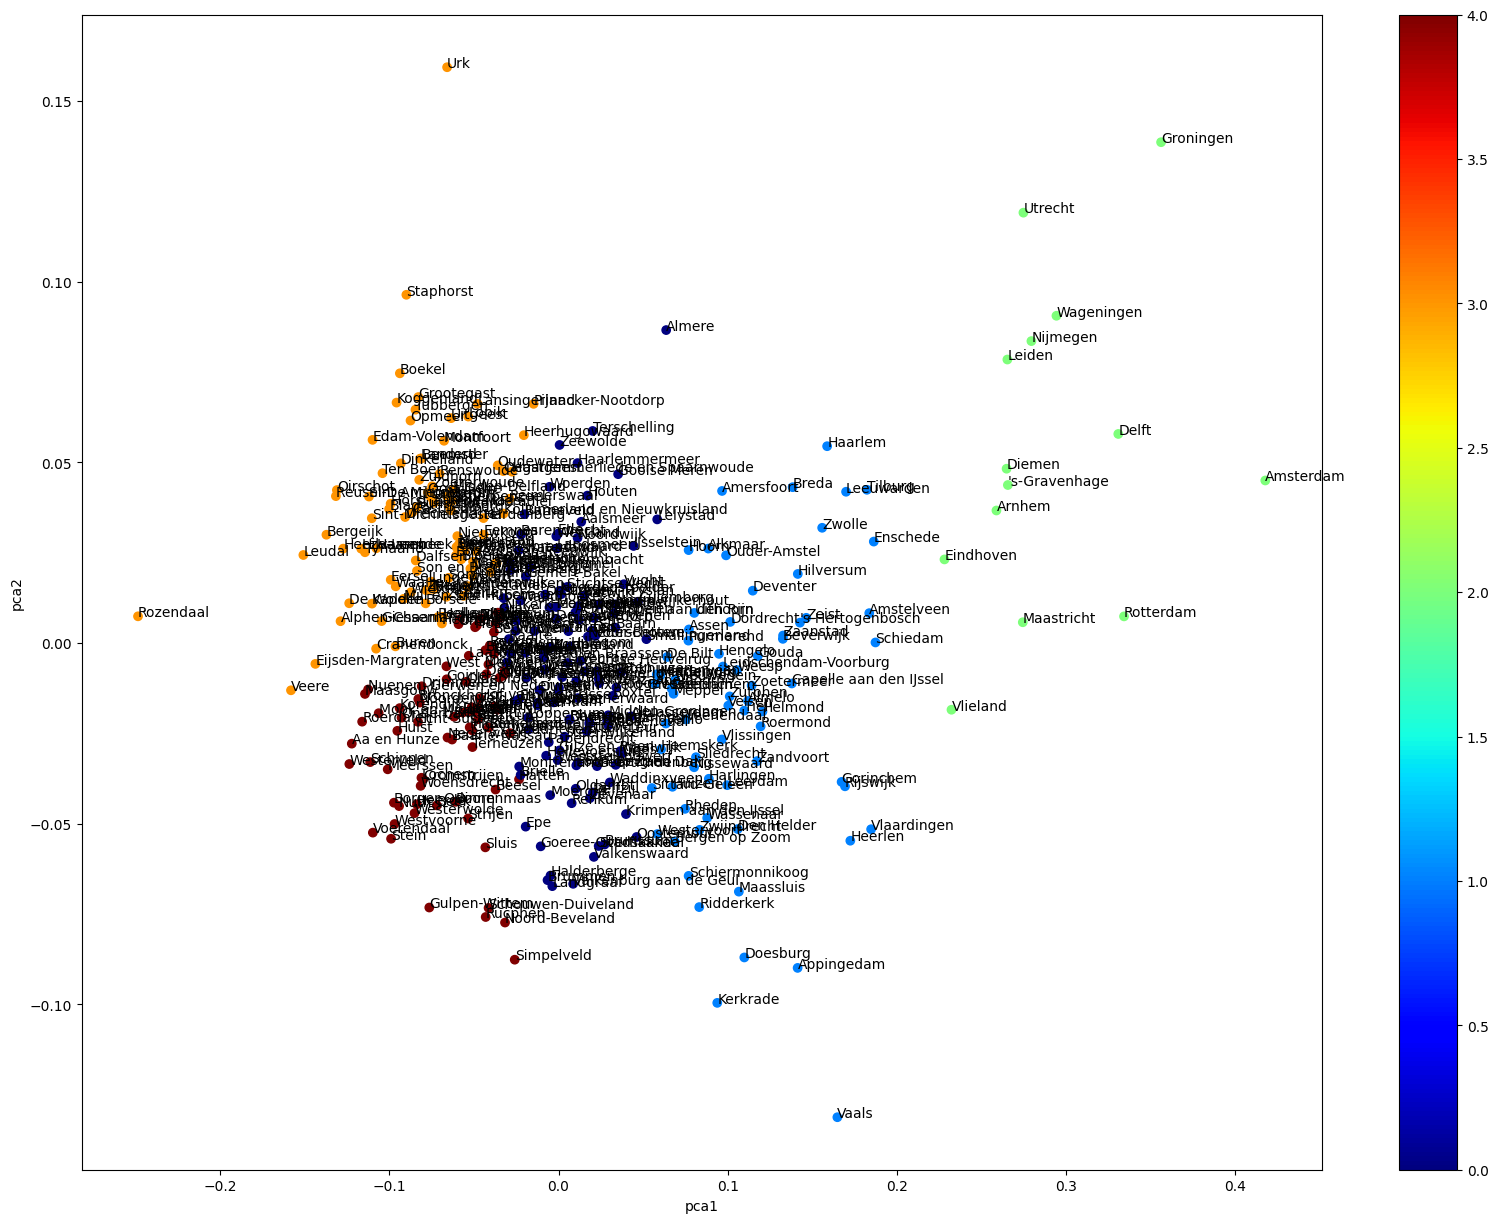

In [23]:
column_reference_table[0] = 'pca1'
column_reference_table[1] = 'pca2'

feature_one = 0
feature_two = 1

plt.scatter(data_reduced_w_cluster[feature_one], data_reduced_w_cluster[feature_two], c=data_reduced_w_cluster['cluster'], cmap=cm.jet)
plt.colorbar()
plt.xlabel(column_reference_table[feature_one])
plt.ylabel(column_reference_table[feature_two])

# comment out for not showing labels
for i, txt in enumerate(data_reduced_w_cluster['gm_naam']):
    x_co = data_reduced_w_cluster.iloc[i][feature_one]
    y_co = data_reduced_w_cluster.iloc[i][feature_two]
    plt.annotate(txt, (x_co, y_co))